<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/variational-algos/cost_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-nam7o37f
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-nam7o37f
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done


Original circuit:


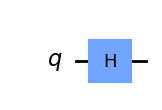

Auxiliary circuit for X


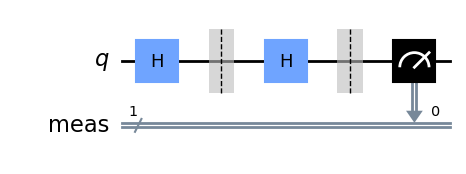

Auxiliary circuit for Z


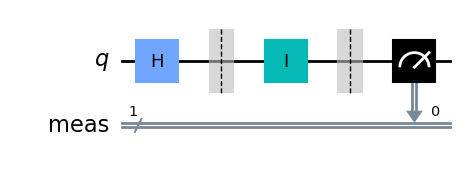

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.i(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)


print("Original circuit:")
display(original_circuit.draw("mpl"))
for (circuit, pauli) in zip(aux_circuits, H.paulis):
    print(f"Auxiliary circuit for {str(pauli)}")
    display(circuit.draw("mpl"))

In [3]:
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np


## SAMPLER
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += Lambda[0][0] * dist.get(0, 0)
    val += Lambda[1][1] * dist.get(1, 0)
    expvals.append(val)


print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")


## ESTIMATOR
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H

estimator = Estimator()
job = estimator.run([original_circuit] * len(observables), observables)
estimator_expvals = job.result().values

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


In [4]:
!pip install -q qiskit-ibm-runtime

In [5]:
%run cred.sh

<Figure size 640x480 with 0 Axes>

In [21]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# Add your token below
#service = QiskitRuntimeService(channel="ibm_quantum")

def cost_function_vqe(theta):
    observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

    reference_circuit = QuantumCircuit(2)
    reference_circuit.x(0)

    variational_form = TwoLocal(
        2,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)

    #backend = service.backend("ibmq_qasm_simulator")
    backend = service.backend("ibmq_qasm_simulator")
    session=Session(backend=backend)
    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=session)
    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=Session(service=service, backend="ibmq_qasm_simulator"))
    job = estimator.run(ansatz, observable, theta)
    values = job.result().values

    return values


theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
cost_function_vqe(theta_list)

array([0.0425])

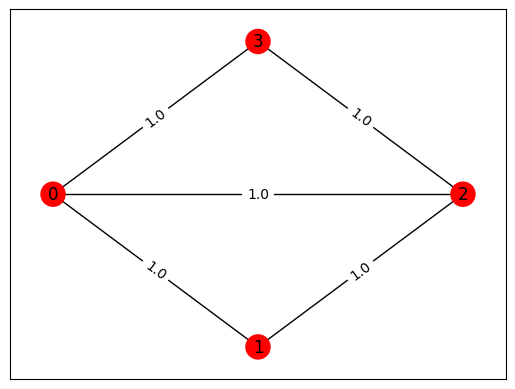

In [22]:
import networkx as nx

n = 4
G = nx.Graph()
G.add_nodes_from(range(n))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edge_list)

colors = ["red" for i in range(n)]


def draw_graph(G, colors):
    """Draws the graph with the chose colors"""
    layout = nx.shell_layout(G)
    nx.draw_networkx(G, node_color=colors, pos=layout)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)


draw_graph(G, colors)

In [9]:
!pip install -q qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [11]:
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms.optimizers import COBYLA

w = nx.to_numpy_array(G)

max_cut = Maxcut(w)
quadratic_program = max_cut.to_quadratic_program()
observable, offset = quadratic_program.to_ising()


def cost_function_max_cut_vqe(theta):

    ansatz = TwoLocal(
        observable.num_qubits, "rx", reps=1
    )

    backend = service.backend("ibmq_qasm_simulator")
    session=Session(backend=backend)
    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=session)
    job = estimator.run(ansatz, observable, theta)
    values = job.result().values

    return values


optimizer = COBYLA()

initial_theta = np.ones(8)

optimizer_result = optimizer.minimize(fun=cost_function_max_cut_vqe, x0=initial_theta)

optimal_parameters = optimizer_result.x
print(optimal_parameters)

[ 1.0662498  -0.44153744  2.03292136  0.06324437  2.11850295  0.48336406
  1.08947398 -0.06794207]


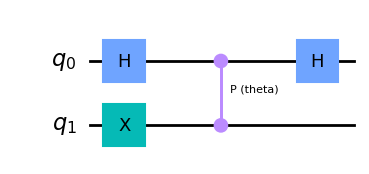

In [12]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

In [13]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [ [phase] for phase in phases]

In [15]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.5 MB/s eta 0:00:00


In [23]:
## Create noise model
## Create noise model
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options


# Make a noise model
fake_backend = FakeSherbrooke()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator.set_backend(fake_backend)

In [24]:
%run cred.sh

<Figure size 640x480 with 0 Axes>

In [25]:
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Estimator

# Add your token below
#service = QiskitRuntimeService(channel="ibm_quantum")

noisy_exp_values = []
exp_values_with_em_es = []

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # generate noisy results
    options.optimization_level = 0
    options.resilience_level = 0

    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    noisy_exp_values = result.values

    options.optimization_level = 3
    options.resilience_level = 2

    # leverage mitigation and suppression
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    exp_values_with_em_es = result.values

    session.close()

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="Noisy")
plt.plot(phases, exp_values_with_em_es, "o", label="Mitigation + Suppression")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="Theory")
plt.xlabel("Phase")
plt.ylabel("Expectation")
plt.legend()
plt.show()